## [SRS-04: Deceleration Strength and Duration over Velocity Distribution](https://codebeamer.bmwgroup.net/cb/issue/3468672) & [[Parameter] Event Rate of SRS04](https://codebeamer.bmwgroup.net/cb/issue/5036345)

### Summary: 
In the following, we fit the model of the joint probability of the brake deceleration, duration and initial velocity to data. The marginal distributions are combined with a Gaussian Copula.

Furthermore, the freqency $\lambda$ of brakings according to the SRS definition is estimated.

TODO: 
- Check outliers and velocity ranges --> Ludwig
- Reference Source of Data --> Ludwig
- Check occurrence rate! --> Moritz
- Remove smoothing noise once non-discretized data is available --> Moritz

In [1]:
import os
import sys
cwd = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(cwd)

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sn
import statsmodels.api as sm
from statsmodels.distributions.copula.api import GaussianCopula
import statsmodels.formula.api as smf
from scipy.stats import norm, lognorm, uniform, gengamma, weibull_max
from scipy import stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from tools.general_utility.helpers import read_and_verify_csv_data
from tools.plot_tools.plot_tools import qqplot
%matplotlib inline 

### Load and Format Data

In [3]:
data_name = 'Emergency_braking_da_1747211666553.csv' # todo cite source here
input_data = read_and_verify_csv_data(data_name)
df = input_data.df
df.head()
#for col in df.columns:
#    print(col)

,braking_event_id,day,driveid[emergency_braking_cdc_oct_09_2024],date,event_object,host_lane_assign,label_end_time,label_start_time,min_delta_acceleration_piecewise_m_s2,min_delta_position_piecewise_m,...,tgt_mean_velocity_m_s,tgt_min_braking_m_s2,tlag_s,worst_xcc_status,first_y_m,mean_y_m,tgt_mean_braking_second_half_m_s2,tgt_mean_braking_first_half_m_s2,tgt_symmetry_factor_from_mean_braking,pp_objtype
0,tgt_000b5e90-c98a-47fa-e8b2-27fe23476dcd_CS20_...,15,000b5e90-c98a-47fa-e8b2-27fe23476dcd,2025-01-15 00:00:00,tgt,middle,1210190,1209090,-0.706687,0.000000,...,15.852761,-1.043542,0.6,0.0,-0.012000,0.055070,-1.274517,-1.900150,1.490878,1
1,tgt_00d35826-97d7-47ca-eb8a-5220993b9ec2_CS4_1...,15,00d35826-97d7-47ca-eb8a-5220993b9ec2,2025-01-15 00:00:00,tgt,left,377040,368940,-2.267430,0.000000,...,12.819018,-1.018953,3.7,0.0,3.949330,1.750043,-1.737221,-1.698965,0.977978,1
2,tgt_00d35826-97d7-47ca-eb8a-5220993b9ec2_CS4_3...,15,00d35826-97d7-47ca-eb8a-5220993b9ec2,2025-01-15 00:00:00,tgt,left,368940,367940,-0.137558,-0.005200,...,20.571240,-1.094167,NaN,0.0,0.851511,0.396395,-1.369240,-2.401424,1.753838,1
3,tgt_00d35826-97d7-47ca-eb8a-5220993b9ec2_CS4_3...,15,00d35826-97d7-47ca-eb8a-5220993b9ec2,2025-01-15 00:00:00,tgt,right,447940,446240,-0.397319,-0.031244,...,3.633630,-1.027143,0.0,0.0,1.575382,1.384218,-0.840476,-5.855275,6.966617,1
4,tgt_00d35826-97d7-47ca-eb8a-5220993b9ec2_CS4_6...,15,00d35826-97d7-47ca-eb8a-5220993b9ec2,2025-01-15 00:00:00,tgt,middle,156140,152940,-0.517701,-0.026621,...,13.891466,-1.033721,NaN,0.0,-1.303166,-0.884643,-1.725893,-1.739588,1.007935,1


In [4]:
df.rename(columns={
        'tgt_mean_braking_m_s2': 'decel', # needs (-1) below
        'tgt_first_velocity_m_s': 'v0',
        'duration_braking_event_s': 'delta_t',
        'symmetry_factor_tgt': 'symmetry_factor',
        'pp_objtype': 'type'
        },inplace=True)

df['source']='measurement'
df['decel'] = (-1)*df['decel'] # 
keep_columns = ['v0', 'decel', 'delta_t', 'symmetry_factor', 'type', 'source']
df = df[keep_columns]
df.head()

,v0,decel,delta_t,symmetry_factor,type,source
0,16.844286,1.309748,1.1,1.242399,1,measurement
1,19.853001,1.625422,8.1,0.954125,1,measurement
2,21.738333,1.643183,1.0,1.753838,1,measurement
3,8.191363,1.850985,1.7,6.192549,1,measurement
4,16.819769,1.611671,3.2,1.007935,1,measurement


In [5]:
len(df.index)

590000

### Filter Outliers

In [6]:
df.drop(df[(df['decel'] < 0.0) ].index,inplace=True) # Filter accelerations
decel_physical_limit = 11.0 # Filter unrealistically high decelerations
df.drop(df[(df['decel'] > decel_physical_limit) ].index,inplace=True);
delta_t_implausable_cutoff = 10.0
df.drop(df[(df['delta_t'] > delta_t_implausable_cutoff) ].index,inplace=True);
df.drop(df[(df['symmetry_factor'] <= 0)].index,inplace=True);
df.drop(df[(df['symmetry_factor'] >= 5)].index,inplace=True);

df['vf'] = df.v0 - df.decel*df.delta_t;
df['delta_v'] = df['v0']-df['vf']
df.drop(df[(df['vf'] < 0.0) ].index,inplace=True);
df.drop(df[(df['v0'] > 80/3.6) ].index,inplace=True);
len(df.index)

C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\645439198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df['decel'] < 0.0) ].index,inplace=True) # Filter accelerations
C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\645439198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df['decel'] > decel_physical_limit) ].index,inplace=True);
C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\645439198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

543345

### Add noise for discretized values
The data samples have been roundet to the second decimal place, which causes significant problems in the model fit and can be avoided by unform noise:

In [7]:
# Safe original data for comparison
decel_discrete = df['decel']
delta_t_discrete = df['delta_t']
v0_discrete = df['v0']
symmetry_factor = df['symmetry_factor']
# Add noise
np.random.seed(12345)
df['decel'] = df['decel'] + np.random.uniform(-0.05, 0.05, len(df.index))
df['delta_t'] = df['delta_t'] + np.random.uniform(-0.05, 0.05, len(df.index))
df['v0'] = df['v0'] + np.random.uniform(-0.05, 0.05, len(df.index))
df['symmetry_factor'] = df['symmetry_factor'] + np.random.uniform(-0.05, 0.05, len(df.index))

C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\420961367.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decel'] = df['decel'] + np.random.uniform(-0.05, 0.05, len(df.index))
C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\420961367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_t'] = df['delta_t'] + np.random.uniform(-0.05, 0.05, len(df.index))
C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\420961367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

### Focus on stronger braking
[[Scenario] SRS-04 Emergency Braking of Front Vehicle](https://codebeamer.bmwgroup.net/cb/issue/2462258) defines 4.0 $m/s^2$ as the threshold for emergency braking. As there is way more data available towards moderate brakings, we estimat the distribution based on data up 3.0 $m/s^2$ and truncate the acceleration distributions at 4.0 $m/s^2 afterwards. Also, there seems to be some inplausible outliers, which will be removed based on the pysical limit.

In [8]:
decel_cut_off_data = 3.0
df.drop(df[(df['decel'] <= decel_cut_off_data) ].index,inplace=True);
len(df.index)

C:\Users\q679802\AppData\Local\Temp\ipykernel_8172\695194258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df['decel'] <= decel_cut_off_data) ].index,inplace=True);


2937

### Sample Marginal Distributions based on Gauß Copula

In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import normflows as nf
from normalizing_flow import normflow, plot_pdf_surface

training_data = df[['v0', 'decel', 'delta_t', 'symmetry_factor', 'type']]

hidden_units = 64
hidden_layers = 2
num_flows = 16
max_iter = 500
batch_size = 256
lr=1e-3

model, context_columns, pdf = normflow(training_data, hidden_units, hidden_layers, num_flows, max_iter, batch_size, lr)

c:\Users\q679802\reliability-engineering-main (1)\reliability-engineering-main\Model_Fits\BK21_VAL\IFM\IFM_data\normalizing_flow.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '392       1
486       1
559       1
921       1
923       1
         ..
588851    1
589380    1
589787    1
589793    1
589871    1
Name: type, Length: 2937, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  training_data.iloc[:, -1] = training_data.iloc[:, -1].astype(str)


KeyboardInterrupt: 

In [ ]:
def normflow(training_data, hidden_units, hidden_layers, num_flows, max_iter, batch_size, lr, lambda_penalty=10.0, decel_cut_off_data=0.1):

    seed = 42
    cols = training_data.columns.tolist()
    cols.remove('type')
    cols.append('type')
    training_data = training_data[cols]

    x_data = training_data.iloc[:, :-1].to_numpy().astype(np.float32)
    training_data.iloc[:, -1] = training_data.iloc[:, -1].astype(str)
    context_df = pd.get_dummies(training_data.iloc[:, -1], prefix='type')
    context_data = context_df.to_numpy().astype(np.float32)

    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    context_data = torch.tensor(context_data, dtype=torch.float32).to(device)

    latent_size = x_data.shape[1]
    context_size = context_data.shape[1]

    flows = []
    for _ in range(num_flows):
        flows.append(
            nf.flows.AutoregressiveRationalQuadraticSpline(
                latent_size, hidden_layers, hidden_units,
                num_context_channels=context_size
            )
        )
        flows.append(nf.flows.LULinearPermute(latent_size))

    base = nf.distributions.DiagGaussian(latent_size, trainable=False)
    target = nf.distributions.target.ConditionalDiagGaussian()
    model = nf.ConditionalNormalizingFlow(base, flows, target).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    best_loss = float('inf')
    best_model_state = None

    def get_invalid_mask(samples):
        v0, decel, delta_t, symmetry = samples[:, 0], samples[:, 1], samples[:, 2], samples[:, 3]
        delta_t_max = v0 / torch.clamp(decel, min=1e-3)
        vf = v0 - decel * delta_t

        invalid = (
            (decel < 0.0) |
            (decel > 11.0) |
            (delta_t > 10.0) |
            (delta_t < 0.5) |
            (symmetry <= 0) |
            (symmetry >= 5) |
            (vf < 0.0) |
            (v0 > (80 / 3.6)) |
            (decel <= decel_cut_off_data)
        )
        return invalid

    for i in tqdm(range(max_iter)):
        idx = torch.randint(0, x_data.shape[0], (batch_size,))
        x_batch = x_data[idx]
        context_batch = context_data[idx]

        loss_kld = model.forward_kld(x_batch, context_batch)

        with torch.no_grad():
            samples_gen, _ = model.sample(batch_size, context_batch)
        mask_invalid = get_invalid_mask(samples_gen)
        loss_filter_penalty = mask_invalid.float().mean()

        loss = loss_kld + lambda_penalty * loss_filter_penalty

        if not torch.isnan(loss) and not torch.isinf(loss):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)

    # Evaluate PDF on training data
    with torch.no_grad():
        log_pdf = model.log_prob(x_data, context_data)
        pdf = torch.exp(log_pdf).cpu().numpy()

    return model, context_df.columns.tolist(), pdf


training_data = df[['v0', 'decel', 'delta_t', 'symmetry_factor', 'type']]

hidden_units = 64
hidden_layers = 2
num_flows = 16
max_iter = 500
batch_size = 256
lr=1e-3
model, context_columns, pdf = normflow(training_data, hidden_units, hidden_layers, num_flows, max_iter, batch_size, lr)

C:\Users\q679802\AppData\Local\Temp\ipykernel_3376\2400628486.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '392       1
486       1
559       1
921       1
923       1
         ..
588851    1
589380    1
589787    1
589793    1
589871    1
Name: type, Length: 2937, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  training_data.iloc[:, -1] = training_data.iloc[:, -1].astype(str)
100%|██████████| 500/500 [10:04<00:00,  1.21s/it]


[Type 1] PDF Surface:


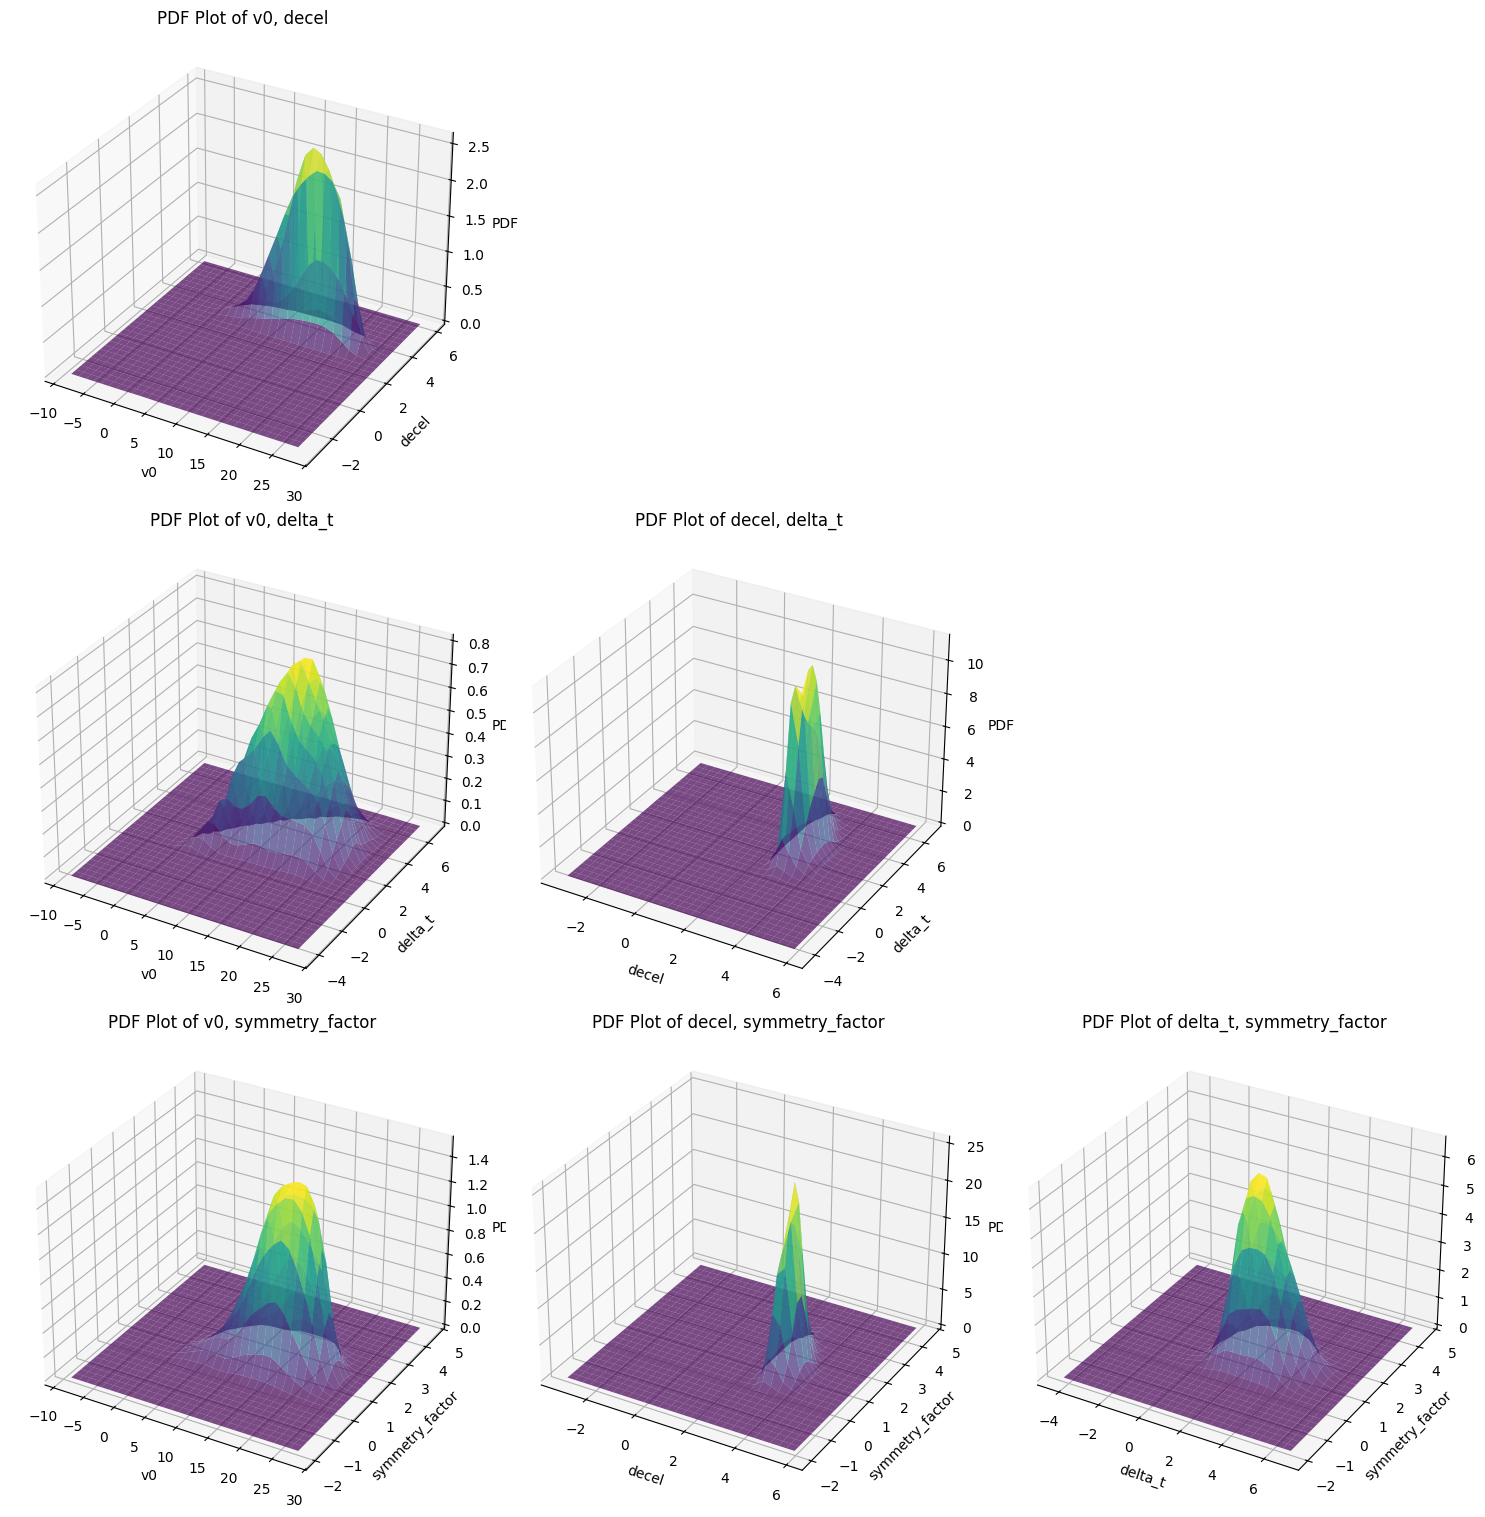

[Type 1] Pairplot:
Measurement sample number: 2899
Filtered model sample number: 2743


<Figure size 1000x1000 with 0 Axes>

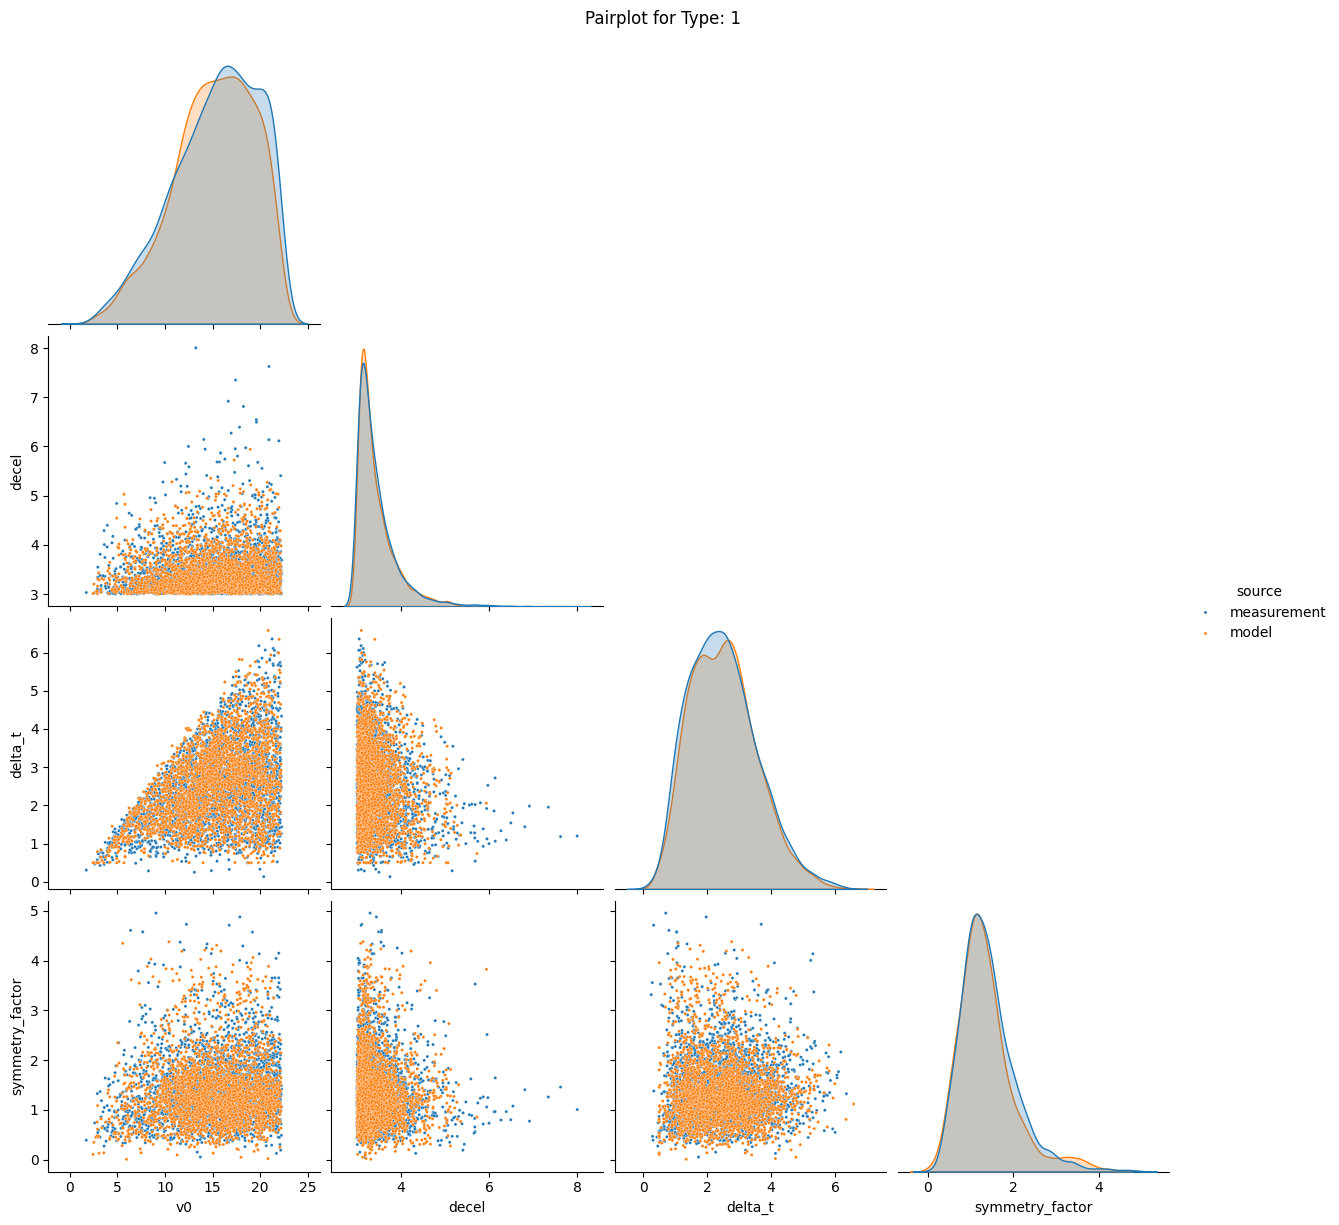

[Type 3] PDF Surface:


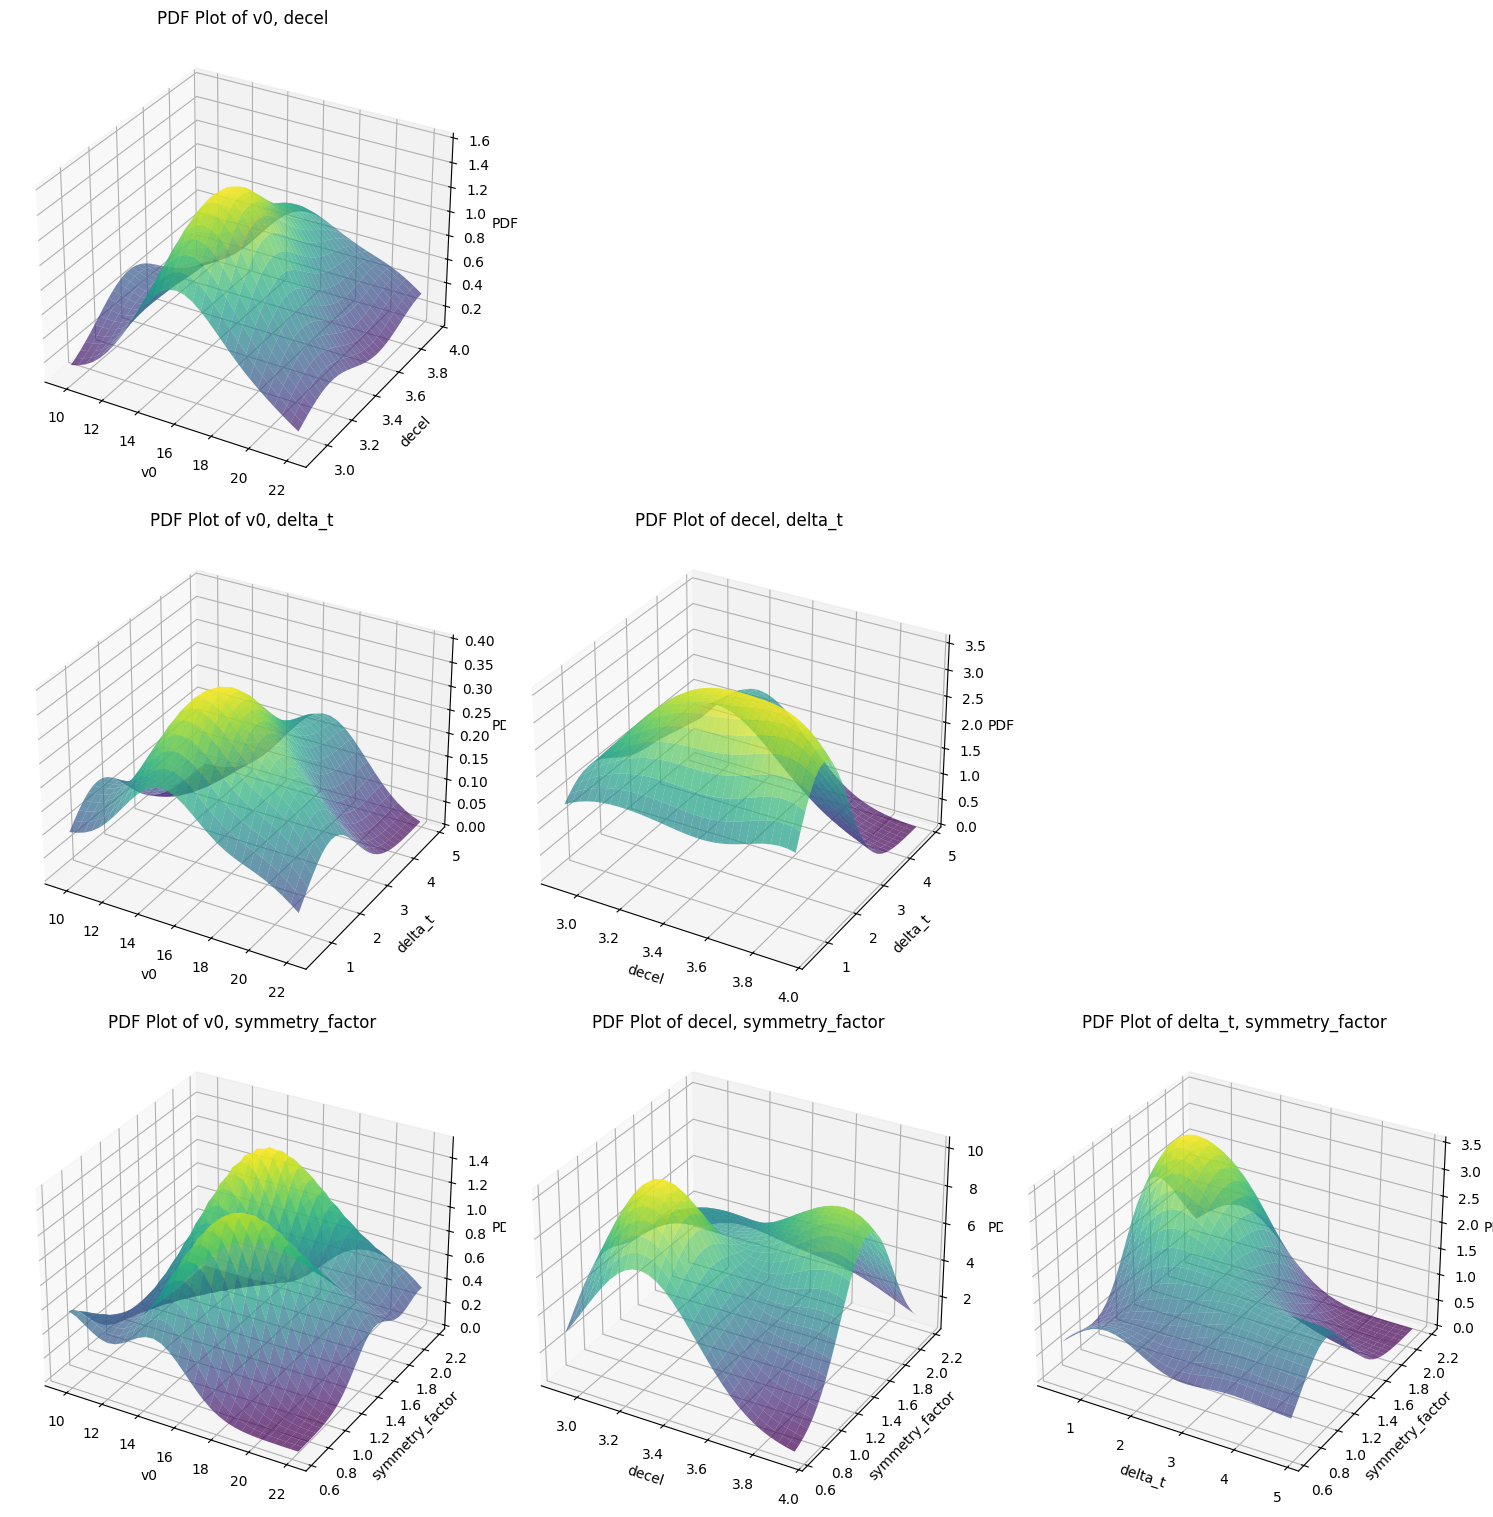

[Type 3] Pairplot:
Measurement sample number: 10
Filtered model sample number: 9


<Figure size 1000x1000 with 0 Axes>

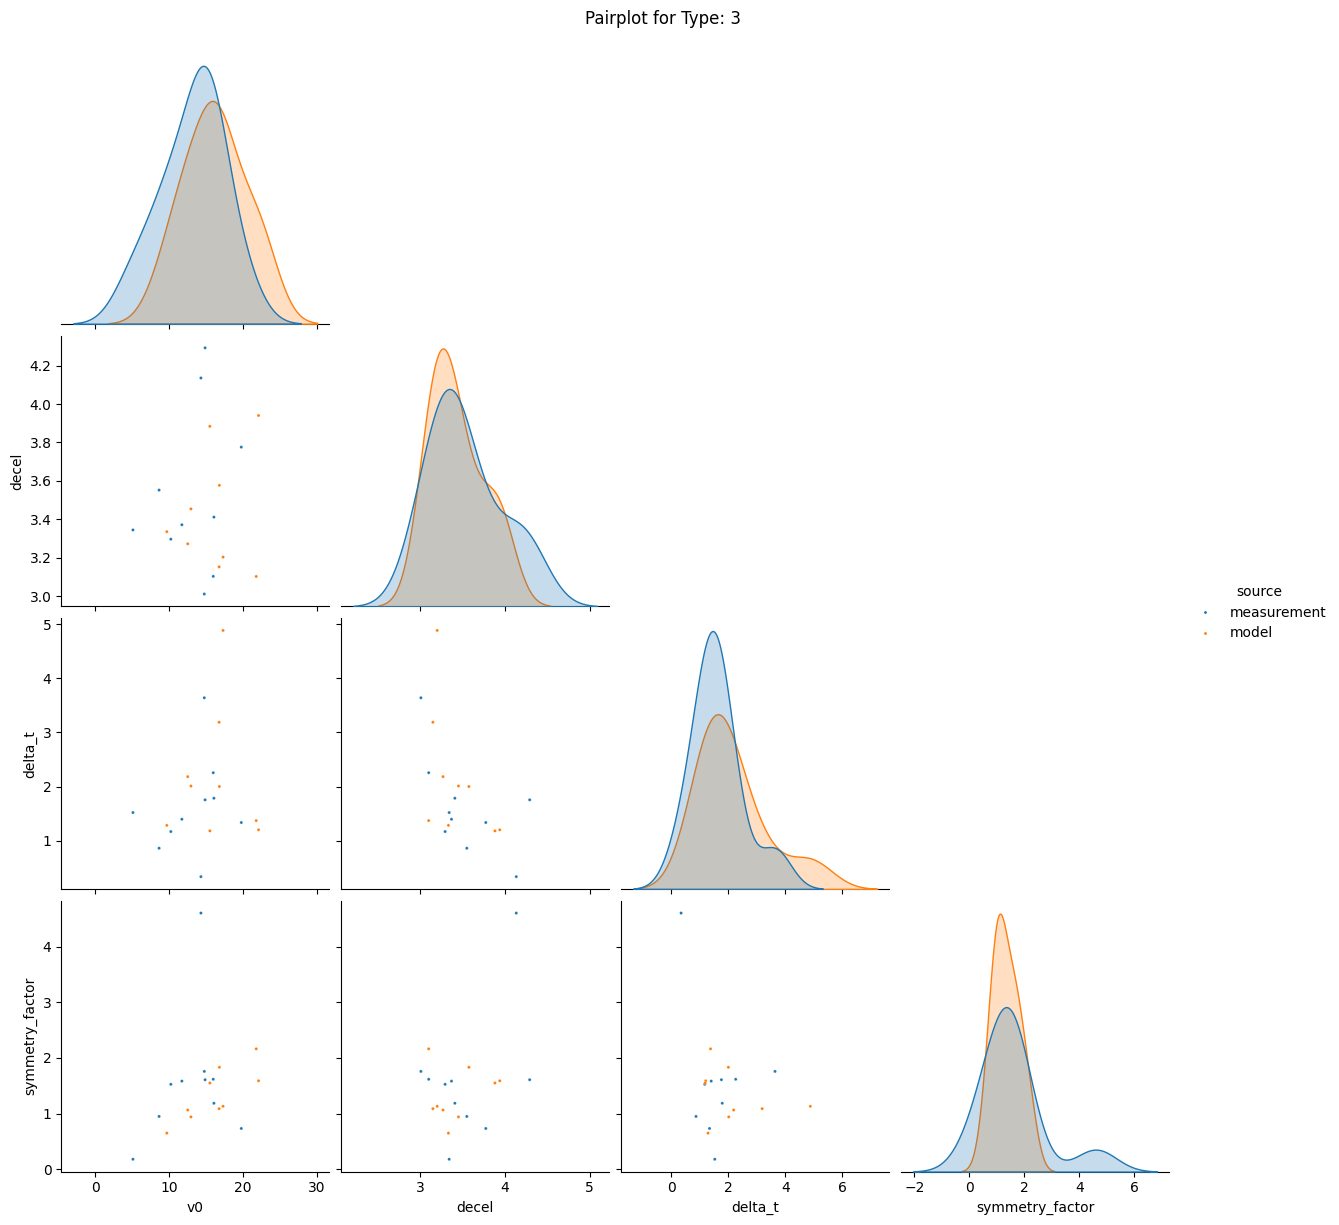

[Type 2] PDF Surface:


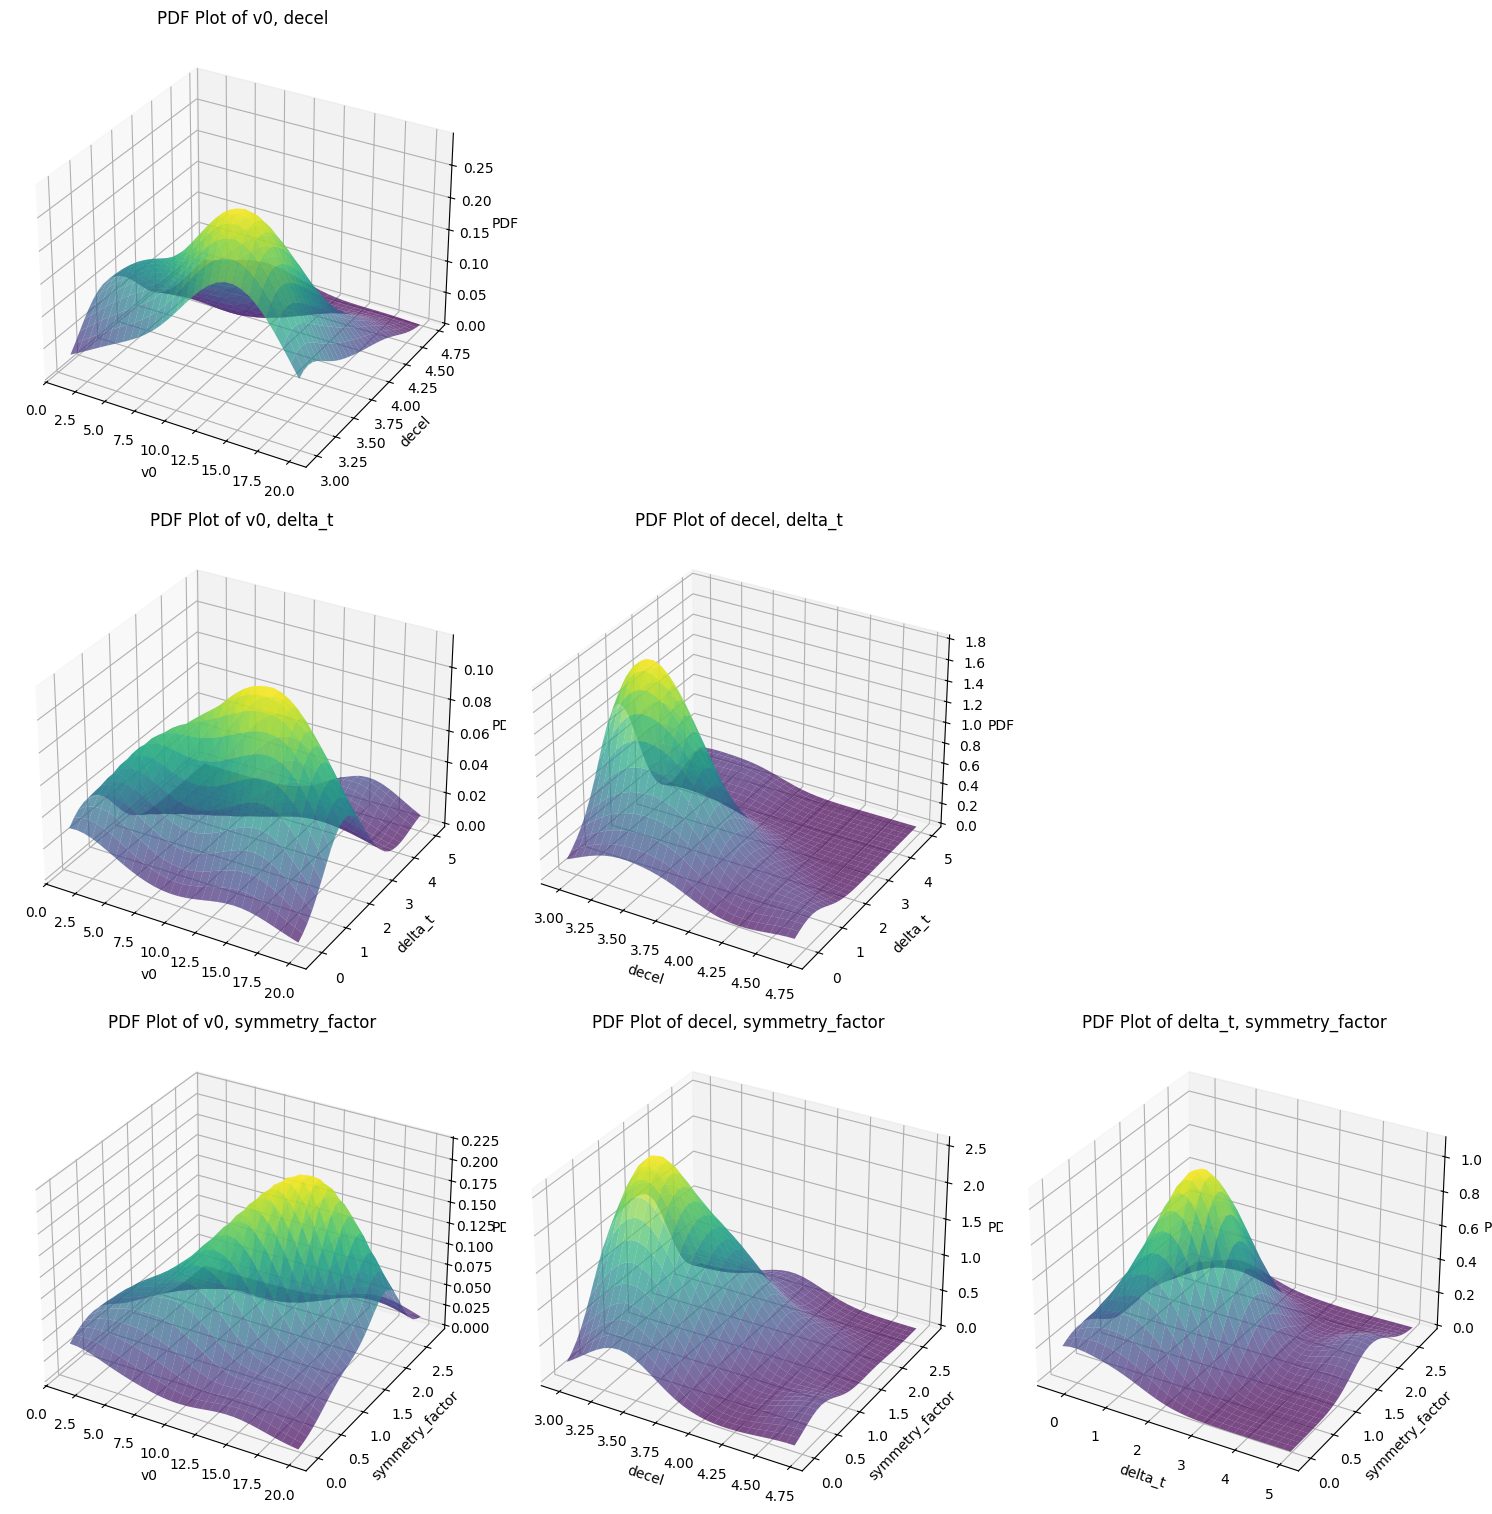

[Type 2] Pairplot:
Measurement sample number: 28
Filtered model sample number: 26


<Figure size 1000x1000 with 0 Axes>

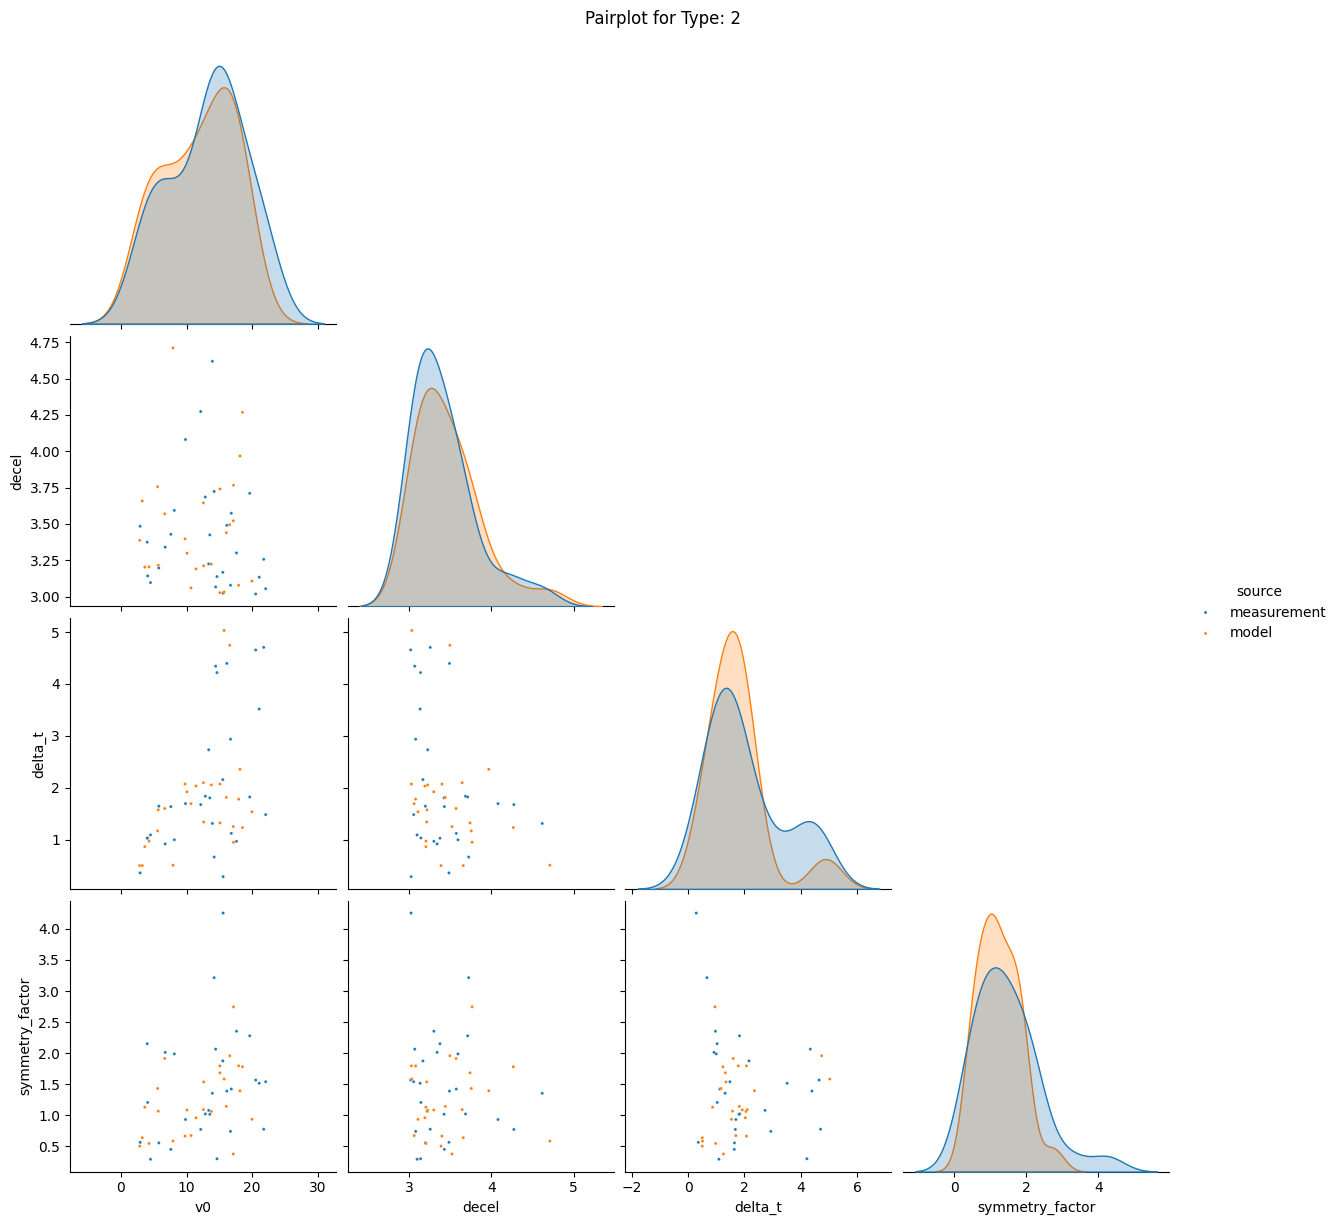

In [ ]:
samples_model = {}
unique_types = training_data['type'].unique().astype(str)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

measurement_df = training_data.copy()
measurement_df['source'] = 'measurement'

plot_subset = ['v0', 'decel', 'delta_t','symmetry_factor', 'source']

for type_name in unique_types:
    n_samples = training_data[training_data['type'] == int(type_name)].shape[0]

    context_vector = torch.zeros((n_samples, len(context_columns)))
    context_vector[:, context_columns.index(f"type_{type_name}")] = 1.0

    with torch.no_grad():
        samples = model.sample(n_samples, context_vector)[0].cpu().numpy()

    log_pdf = model.log_prob(torch.tensor(samples, dtype=torch.float32).to(device), context_vector.to(device))
    pdf_values = torch.exp(log_pdf).cpu().detach().numpy()

    samples_df = pd.DataFrame(samples, columns=['v0', 'decel', 'delta_t', 'symmetry_factor'])
    samples_df['pdf'] = pdf_values
    print(f"[Type {type_name}] PDF Surface:")
    plot_pdf_surface(samples_df)

    v0, decel, delta_t, symmetry_factor = samples[:, 0], samples[:, 1], samples[:, 2], samples[:, 3]
    delta_t_max = v0 / decel
    delta_t = np.maximum(np.minimum(delta_t, delta_t_max), 0.5)

    model_df = pd.DataFrame({
        'v0': v0,
        'decel': decel,
        'delta_t': delta_t,
        'symmetry_factor': symmetry_factor,
        'pdf': pdf_values,
        'source': 'model',
        'type': type_name
    })

    model_df = model_df[
        (model_df['decel'] >= 0.0) &
        (model_df['decel'] <= 11.0) &
        (model_df['delta_t'] <= 10.0) &
        (model_df['symmetry_factor'] > 0) &
        (model_df['symmetry_factor'] < 5)
    ]

    model_df['vf'] = model_df.v0 - model_df.decel * model_df.delta_t
    model_df['delta_v'] = model_df['v0'] - model_df['vf']
    model_df = model_df[
        (model_df['vf'] >= 0.0) &
        (model_df['v0'] <= 80 / 3.6) &
        (model_df['decel'] > decel_cut_off_data)
    ]

    samples_model[type_name] = model_df

    measurement_subset = measurement_df[measurement_df['type'] == int(type_name)].copy()
    model_subset = model_df.copy()

    combined_df = pd.concat([
        measurement_subset[plot_subset],
        model_subset[plot_subset]
    ], ignore_index=True)

    print(f"[Type {type_name}] Pairplot:")
    print('Measurement sample number:', measurement_subset.shape[0])
    print('Filtered model sample number:', model_subset.shape[0])

    plt.figure(figsize=(10, 10))
    sns.pairplot(data=combined_df, hue='source', height=3.0, plot_kws={"s": 5}, corner=True)
    plt.suptitle(f'Pairplot for Type: {type_name}', y=1.02)
    plt.show()


Best parameters:
batch_size: 256
hidden_size: 128
lr: 0.001
num_layers: 16
Best loss: 3.833644151687622

Get cdf error of the final model

### Compare Correlation between model and data in physical space

In [ ]:
np.corrcoef([df['v0'].to_numpy(), df['decel'].to_numpy(), df['delta_t'].to_numpy()])

array([[ 1.        ,  0.08153554,  0.62587203],
       [ 0.08153554,  1.        , -0.17923243],
       [ 0.62587203, -0.17923243,  1.        ]])

### Compute Occurrence Rate
Recorded time $t_r$: [[Distribution] Baseline Germany](https://codebeamer.bmwgroup.net/cb/issue/6302578)

SRS Definition:
- $decel \geq 4.0 m/s^2$
- $\Delta_v \leq -10.0 km/h$

In [ ]:
t_r = 36539 # unit: h
df_filtered = df[['v0', 'decel', 'delta_t', 'source']].copy()
delta_v_thresh = -10./3.6
df_filtered['too_short'] = np.where((-1)*df_filtered['delta_t']*df_filtered['decel'] < delta_v_thresh, 0, 1)

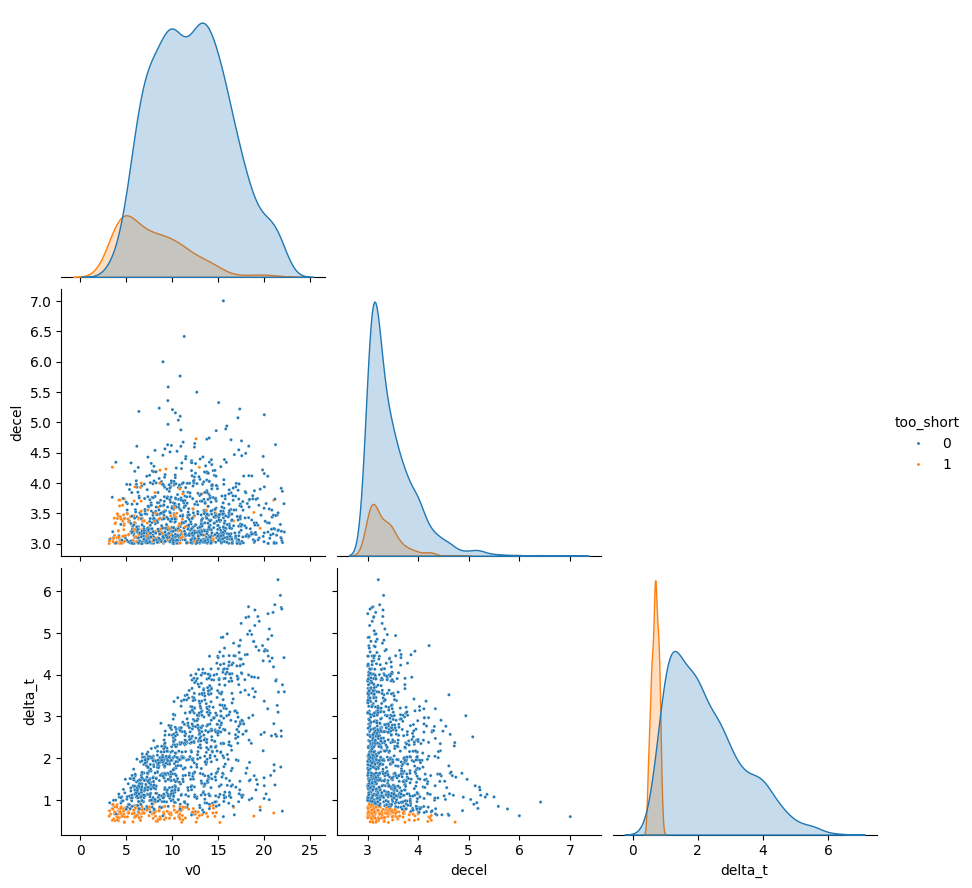

In [ ]:
sns.pairplot(data = df_filtered, hue = 'too_short', height=3.0, plot_kws={"s": 5}, corner=True)

In [ ]:
print(len(df_filtered.index))
df_filtered.drop(df_filtered[(df_filtered['too_short'] == 1) ].index,inplace=True)
print(len(df_filtered.index))

1152
986


In [ ]:
df_filtered.drop(df_filtered[(df_filtered['decel'] <= 4.0)].index,inplace=True)
num_samples_within_SRS = len(df_filtered.index)
print(num_samples_within_SRS)

117


In [ ]:
occurrence_rate = num_samples_within_SRS / t_r # unit: 1/h

TODO: This needs to be updated in [[Parameter] Event Rate of SRS04](https://codebeamer.bmwgroup.net/cb/issue/5036345)

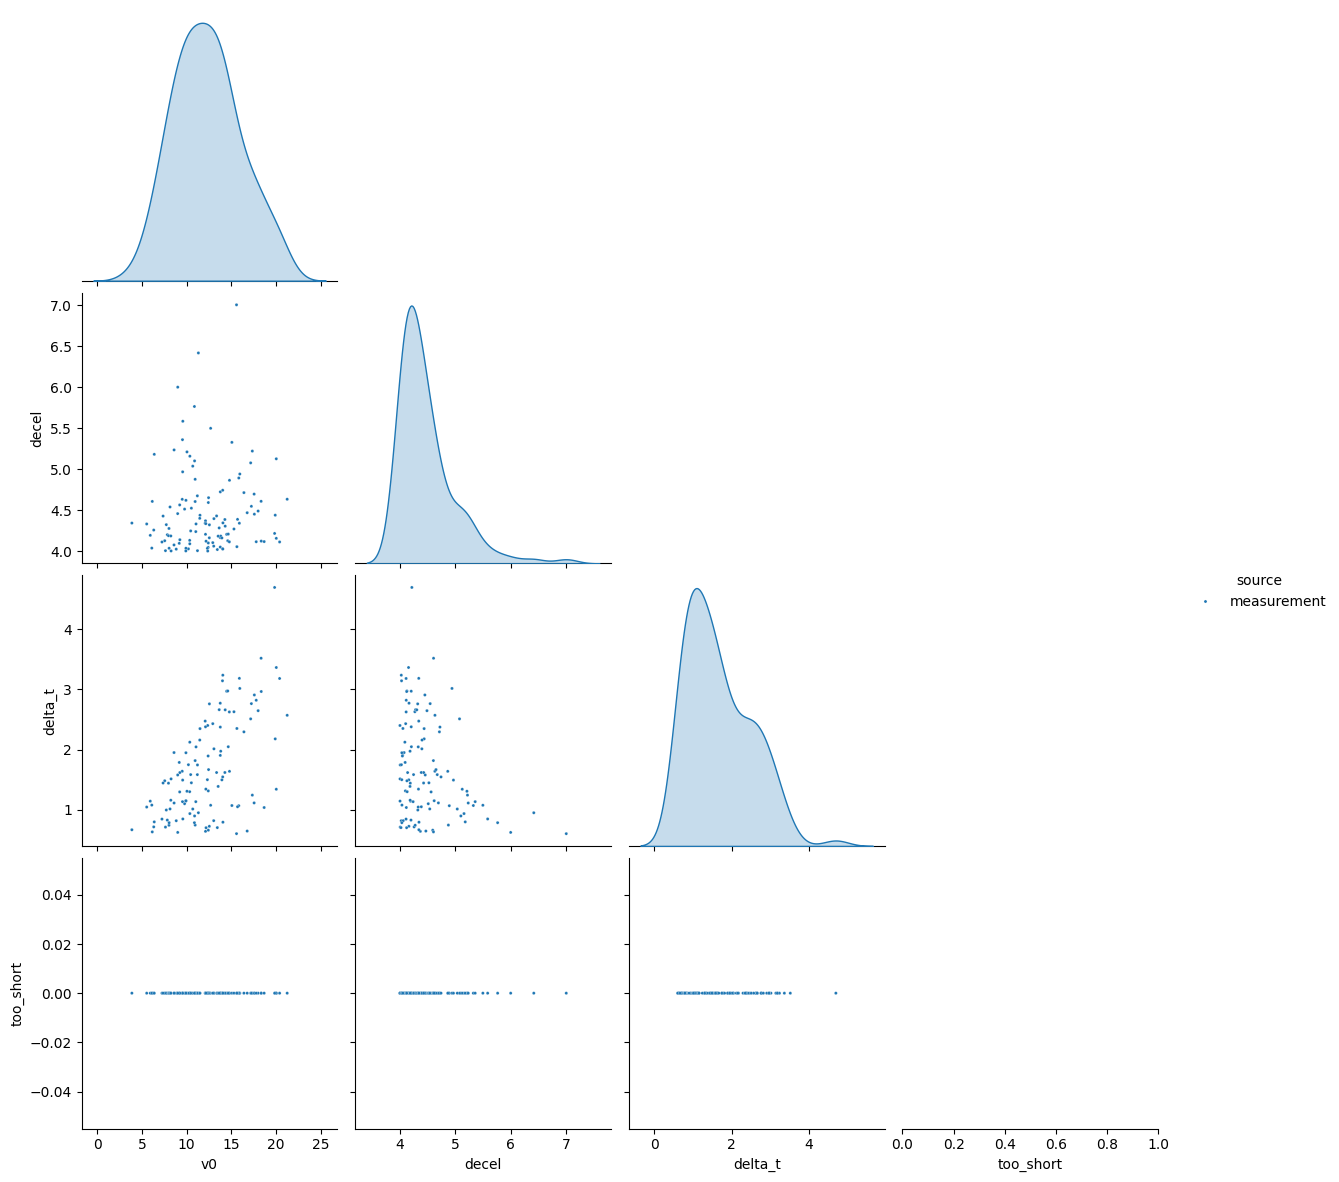

In [ ]:
sns.pairplot(data = df_filtered, hue = 'source', height=3.0, plot_kws={"s": 5}, corner=True)

### Export Model and Generate Tests

In [ ]:
import json
    
def print_distribution(name, dist):
    print(name + ': ' + dist.dist.name)
    print(json.dumps(dist.args, indent=4))
    
def generate_test_data(distribution, number_of_tests, seed):
    np.random.seed(seed)
    U_noise = list(uniform.rvs(size=number_of_tests))
    test_data = {'U_noise': U_noise,
                 'Y_predict': list(distribution.ppf(U_noise))
            }
    return json.dumps(test_data, indent=4)

In [ ]:
n_test = 3
print_distribution('v0', v0_dist)
print(generate_test_data(v0_dist, n_test, 1235))
print_distribution('decel', decel_dist)
print(generate_test_data(decel_dist, n_test, 4232))
print_distribution('delta_t', delta_t_dist)
print(generate_test_data(delta_t_dist, n_test, 3423))
print('Remark: delta_t needs to be saturated, for samples where the vehicle would drive backwards otherwise.')
print('correlationt_matrix: ')
print(corrcoef)

print('occurrence rate (TODO!):')
print(occurrence_rate)

v0: gengamma
[
    0.43194641898620445,
    3.554174523018233,
    3.045134059117429,
    13.688320806693504
]
{
    "U_noise": [
        0.9537625822517408,
        0.9921264707372405,
        0.4796029245278556
    ],
    "Y_predict": [
        19.222261730418477,
        22.2215293934881,
        11.117819897257203
    ]
}
decel: gengamma
[
    0.9363835091375676,
    0.968724534395222,
    3.0005761570248093,
    0.474744972616908
]
{
    "U_noise": [
        0.8032933892520011,
        0.08900138880401831,
        0.9039348882578405
    ],
    "Y_predict": [
        3.737435649912464,
        3.033963872032261,
        4.087305279061926
    ]
}
delta_t: gamma
[
    1.4967014499892148,
    0.4504233569738053,
    1.0472248101474095
]
{
    "U_noise": [
        0.21936740651831355,
        0.0053672010365355405,
        0.2634164089852098
    ],
    "Y_predict": [
        1.0164775088346516,
        0.4894722516517478,
        1.1123044121388892
    ]
}
Remark: delta_t needs to be s